
# Mini-abstract
 **The Credit Scoring dataset has 21 explanotory variables describibng relevenat financial parameters of private borrowers. For our project, we will use these data to develop a Machine Learning model to predict a probability that a person will experience a financial distress. The main performance metricы we will use are ROC-AUC (The receiver operating characteristic-Area Under the Curve) and GINI Index as common tools used in binary classification.**
#### **The data source:** Lending Club (the former largest p-2-p lending platform)
---



# 1. Loading the data. Brief description.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
! pip install scorecardpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 840.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60634 sha256=be4387897d92d4380e8d751575074c92a0d0e67912dae356bcdca3b7352a6a4e
  Stored in directory: /root/.cache/pip/wheels/49/49/e9/7b845548eed3624ce37effdd13e9cb95a99272d692eb9e9e23
Successfully built scorecardpy


In [6]:
! pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 784.7 kB/s eta 0:00:00


In [7]:
! pip install optbinning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.6/211.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 29.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver doe

In [26]:
'''Main'''
import pandas as pd
import numpy as np

'''Data Viz'''
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

'''Data Prep'''
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
import scorecardpy as sc # no active module WOE nowadays (at least we havn't found a working one)
from category_encoders import WOEEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from optbinning import OptimalBinning


'''Models'''
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import lightgbm as lgb

'''HP Tuning'''
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

'''Metrics'''
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [9]:
nc = pd.read_csv('/content/drive/MyDrive/RISK MANAGEMENT/new_clients_for_scoring.csv')
print(nc.shape)
nc.head()

(60333, 22)


,client_id,issue_d,purpose,addr_state,sub_grade,home_ownership,emp_title,dti,funded_amnt,annual_inc,...,inq_last_6mths,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt
0,0,6/1/2014,credit_card,AR,A5,RENT,Property Manager,26.72,15000,45000.0,...,0,9.0,0,0,0,0,4,7245,56948,0
1,1,6/1/2014,credit_card,VA,C4,MORTGAGE,VP Sales,12.62,31500,200000.0,...,2,0.0,1,0,0,0,4,54598,641658,0
2,2,6/1/2014,credit_card,TX,A4,RENT,Engineer in Training,27.72,6400,46500.0,...,0,7.0,0,0,0,0,3,8376,120218,0
3,3,6/1/2014,debt_consolidation,TX,D3,MORTGAGE,Manager,25.68,15000,68700.0,...,0,18.0,2,0,2,1,3,5028,70899,0
4,4,6/1/2014,other,VA,C2,MORTGAGE,Sr. Acct. Mgr.,6.80,3000,114435.0,...,0,8.0,0,0,0,0,2,28455,281150,0


In [27]:
df = pd.read_csv('/content/drive/MyDrive/RISK MANAGEMENT/data.csv')
print(df.shape)
df.head()

(61169, 22)


,issue_d,purpose,addr_state,sub_grade,home_ownership,emp_title,dti,funded_amnt,annual_inc,emp_length,...,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt,def
0,4/1/2010,major_purchase,NY,B5,RENT,new york HRC,4.58,6000,60000.0,2.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0
1,4/1/2010,debt_consolidation,NY,C1,RENT,Harris RF Communications,13.98,12000,64450.0,3.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0
2,4/1/2010,debt_consolidation,VA,B5,MORTGAGE,AT&T Government Solutions,20.16,24000,90000.0,2.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0
3,4/1/2010,debt_consolidation,VA,B5,MORTGAGE,Information Analysis Inc.,22.05,6000,79500.0,1.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0
4,4/1/2010,home_improvement,WA,A4,RENT,US Government,0.94,10000,58608.0,4.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61169 entries, 0 to 61168
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   issue_d                   61169 non-null  object 
 1   purpose                   61169 non-null  object 
 2   addr_state                61169 non-null  object 
 3   sub_grade                 61169 non-null  object 
 4   home_ownership            61169 non-null  object 
 5   emp_title                 57304 non-null  object 
 6   dti                       61169 non-null  float64
 7   funded_amnt               61169 non-null  int64  
 8   annual_inc                61169 non-null  float64
 9   emp_length                58495 non-null  float64
 10  term                      61169 non-null  int64  
 11  inq_last_6mths            61169 non-null  int64  
 12  mths_since_recent_inq     47640 non-null  float64
 13  delinq_2yrs               61169 non-null  int64  
 14  charge

### Variable Name Description

- **issue_d** The month which the loan was funded
- **purpose** A category provided by the borrower for the loan request
- **addr_state** The state provided by the borrower in the loan application
- **sub_grade** External assigned loan subgrade
- **home_ownership** The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
- **emp_title** The job title supplied by the Borrower when applying for the loan
- **dti** A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income
- **funded_amnt** The total amount committed to that loan at that point in time
- **annual_inc** The self-reported annual income provided by the borrower during registration
- **emp_length** Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years
- **term** The number of payments on the loan. Values are in months and can be either 36 or 60
- **inq_last_6mths** The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
- **mths_since_recent_inq** Months since most recent inquiry
- **delinq_2yrs** The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- **chargeoff_within_12_mths** Number of charge-offs within 12 months
- **num_accts_ever_120_pd** Number of accounts ever 120 or more days past due
- **num_tl_90g_dpd_24m** Number of accounts 90 or more days past due in last 24 months
- **acc_open_past_24mths** Number of trades opened in past 24 months
- **avg_cur_bal** Average current balance of all accounts
- **tot_hi_cred_lim** Total high credit/credit limit
- **delinq_amnt** The past-due amount owed for the accounts on which the borrower is now delinquent
- **def** Default indicator

**Our variable of interst is a binary outcome variable**.
When dealing with such a case, there are several machine learning algorithms commonly used for prediction. Here are some of the most commonly used algorithms for binary classification tasks:

1. Logistic Regression

2. Decision Trees and Random Forest

3. Support Vector Machines (SVM)

4. K-Nearest Neighbors (KNN)

5. Naive Bayes

6. Neural Networks (Deep Learning)

7. Gradient Boosting Algorithms

8. Logistic Regression with Regularization

The choice of the most suitable algorithm will depend on the specific characteristics of our dataset, the complexity of the problem. It's often a good practice to try multiple algorithms and compare their performance using cross-validation to select the one that works best for our binary classification task.

**We are going to start with comparing the following three algorithms:**
- **Logistic Regression**

Logistic regression is a classic algorithm for binary classification. It models the probability of the binary outcome based on a linear combination of predictor variables and applies the logistic function to the result.

- **a Decision Tree** (most likely a Random Forest)

Decision trees can be used for binary classification by splitting the dataset into subsets based on feature values and creating a tree-like structure to make predictions. Random Forest is an ensemble method based on several decision trees.

- **a Gradient Boosting Algorithms**

In addition to decision trees, gradient boosting algorithms like XGBoost, LightGBM, and CatBoost can be used directly for binary classification tasks. They are known for their high predictive accuracy and robustness.

## Feature engeneering

In [29]:
income_brackets = [-1, 50000, 100000, 150000, float('inf')]
income_labels = ['Low', 'Medium', 'High', 'Very High']
df['income_category'] = pd.cut(df['annual_inc'], bins=income_brackets, labels=income_labels)
df['income_category'].value_counts()

Medium       30397
Low          20821
High          7351
Very High     2600
Name: income_category, dtype: int64

In [30]:
emp_length_brackets = [-1, 1, 3, 5, 10, float('inf')]
emp_length_labels = ['<1yr', '1-3yrs', '3-5yrs', '5-10yrs', '>10yrs']
df['emp_length_category'] = pd.cut(df['emp_length'], bins=emp_length_brackets, labels=emp_length_labels)
df['emp_length_category'].value_counts()

5-10yrs    32044
1-3yrs     10122
<1yr        8322
3-5yrs      8007
>10yrs         0
Name: emp_length_category, dtype: int64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61169 entries, 0 to 61168
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   issue_d                   61169 non-null  object  
 1   purpose                   61169 non-null  object  
 2   addr_state                61169 non-null  object  
 3   sub_grade                 61169 non-null  object  
 4   home_ownership            61169 non-null  object  
 5   emp_title                 57304 non-null  object  
 6   dti                       61169 non-null  float64 
 7   funded_amnt               61169 non-null  int64   
 8   annual_inc                61169 non-null  float64 
 9   emp_length                58495 non-null  float64 
 10  term                      61169 non-null  int64   
 11  inq_last_6mths            61169 non-null  int64   
 12  mths_since_recent_inq     47640 non-null  float64 
 13  delinq_2yrs               61169 non-null  int6

In [ ]:
# Target's Mean
mean_def = df['def'].mean()
mean_def

0.1595906423188216

Proportion of People Who Defaulted: 0.1595906423188216


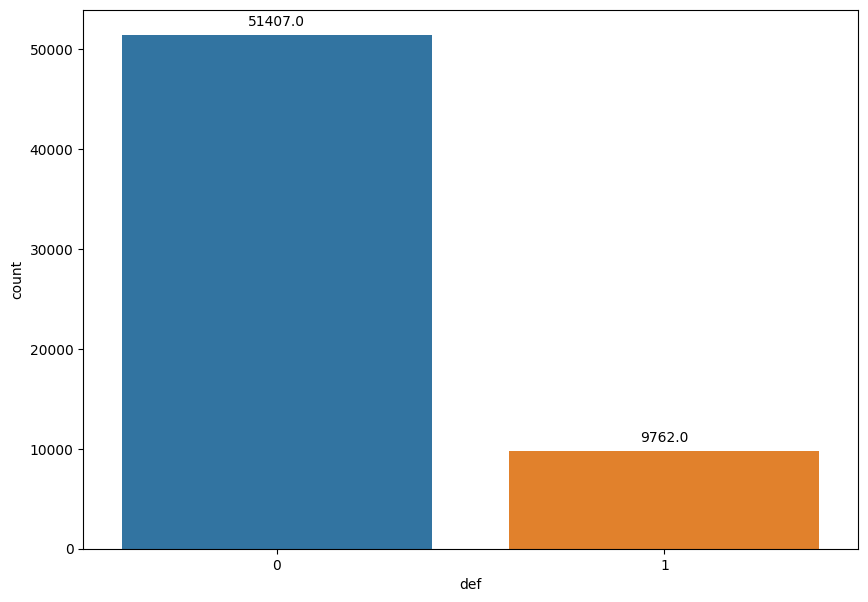

In [ ]:
plt.figure(figsize=(10, 7))
ax = sns.countplot(x="def", data=df)
# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
print("Proportion of People Who Defaulted: {}".format(df["def"].sum() / len(df)))
plt.show()

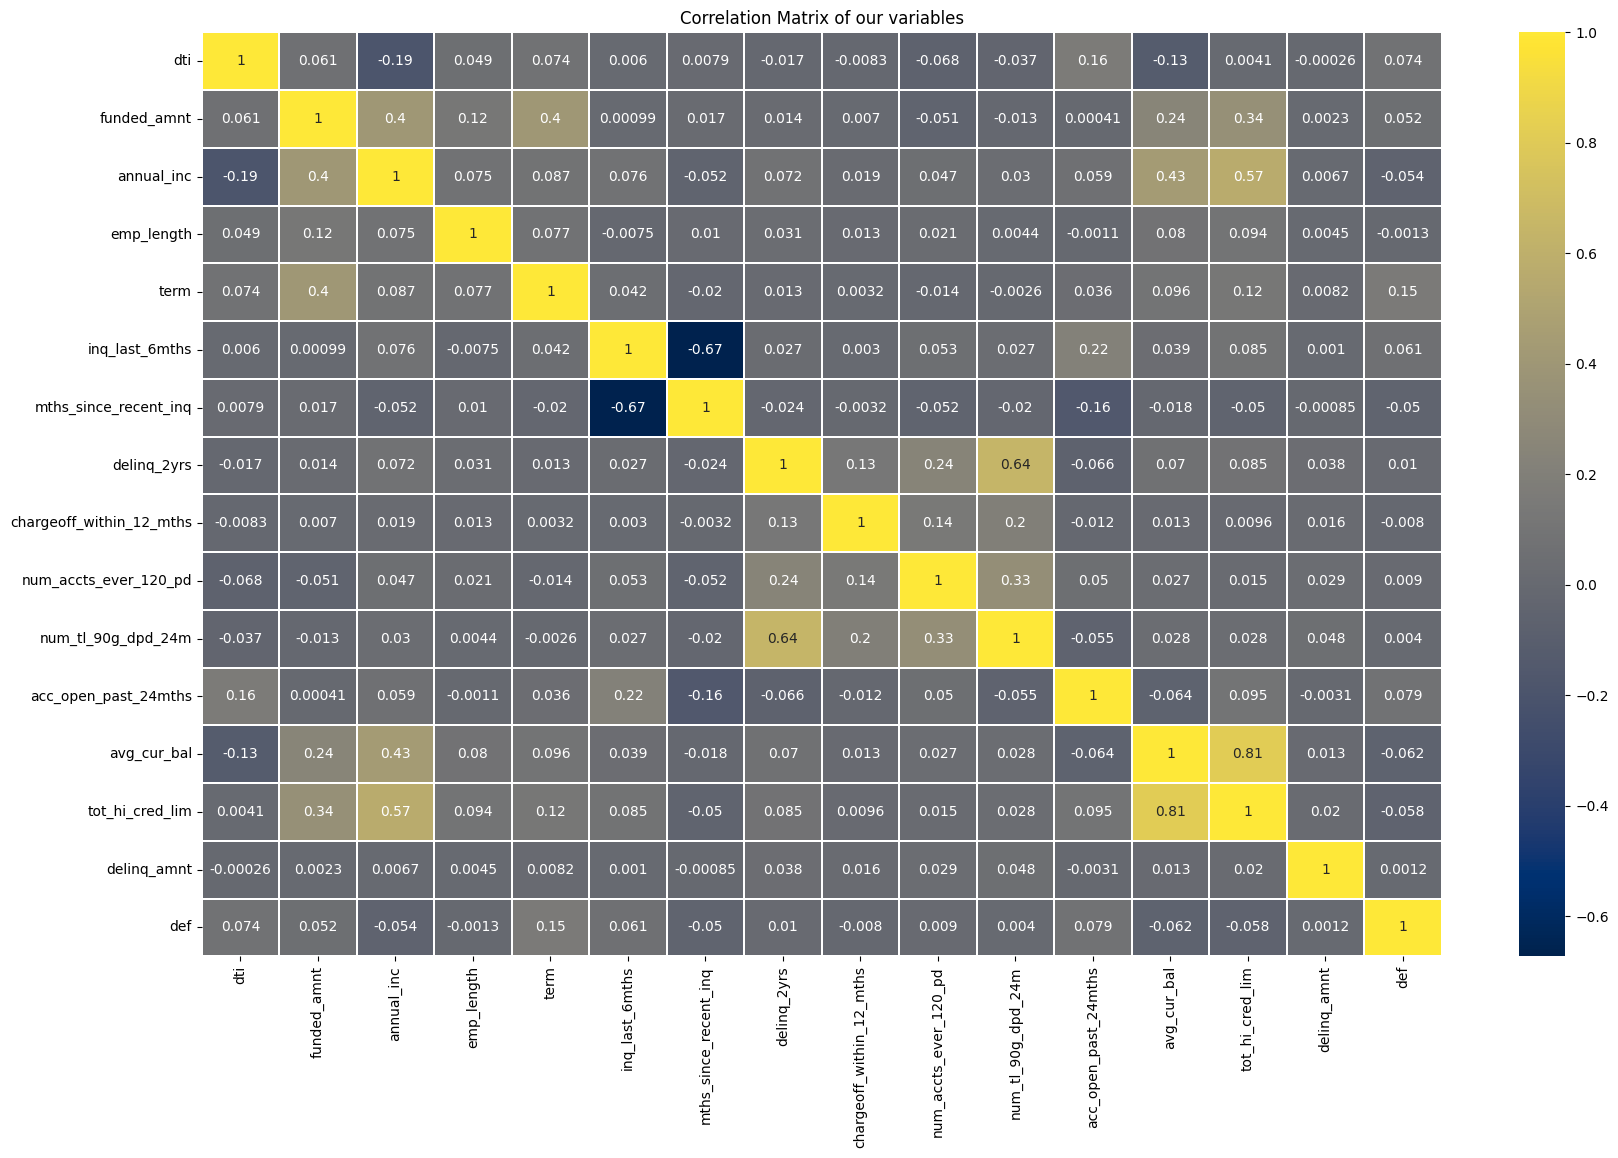

In [ ]:
# Calculating the correlation matrix
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlation_matrix = df[numerical_cols].corr()

# Creating a heatmap of the correlation matrix
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='cividis', linewidths=0.3)
plt.title('Correlation Matrix of our variables')
plt.show()


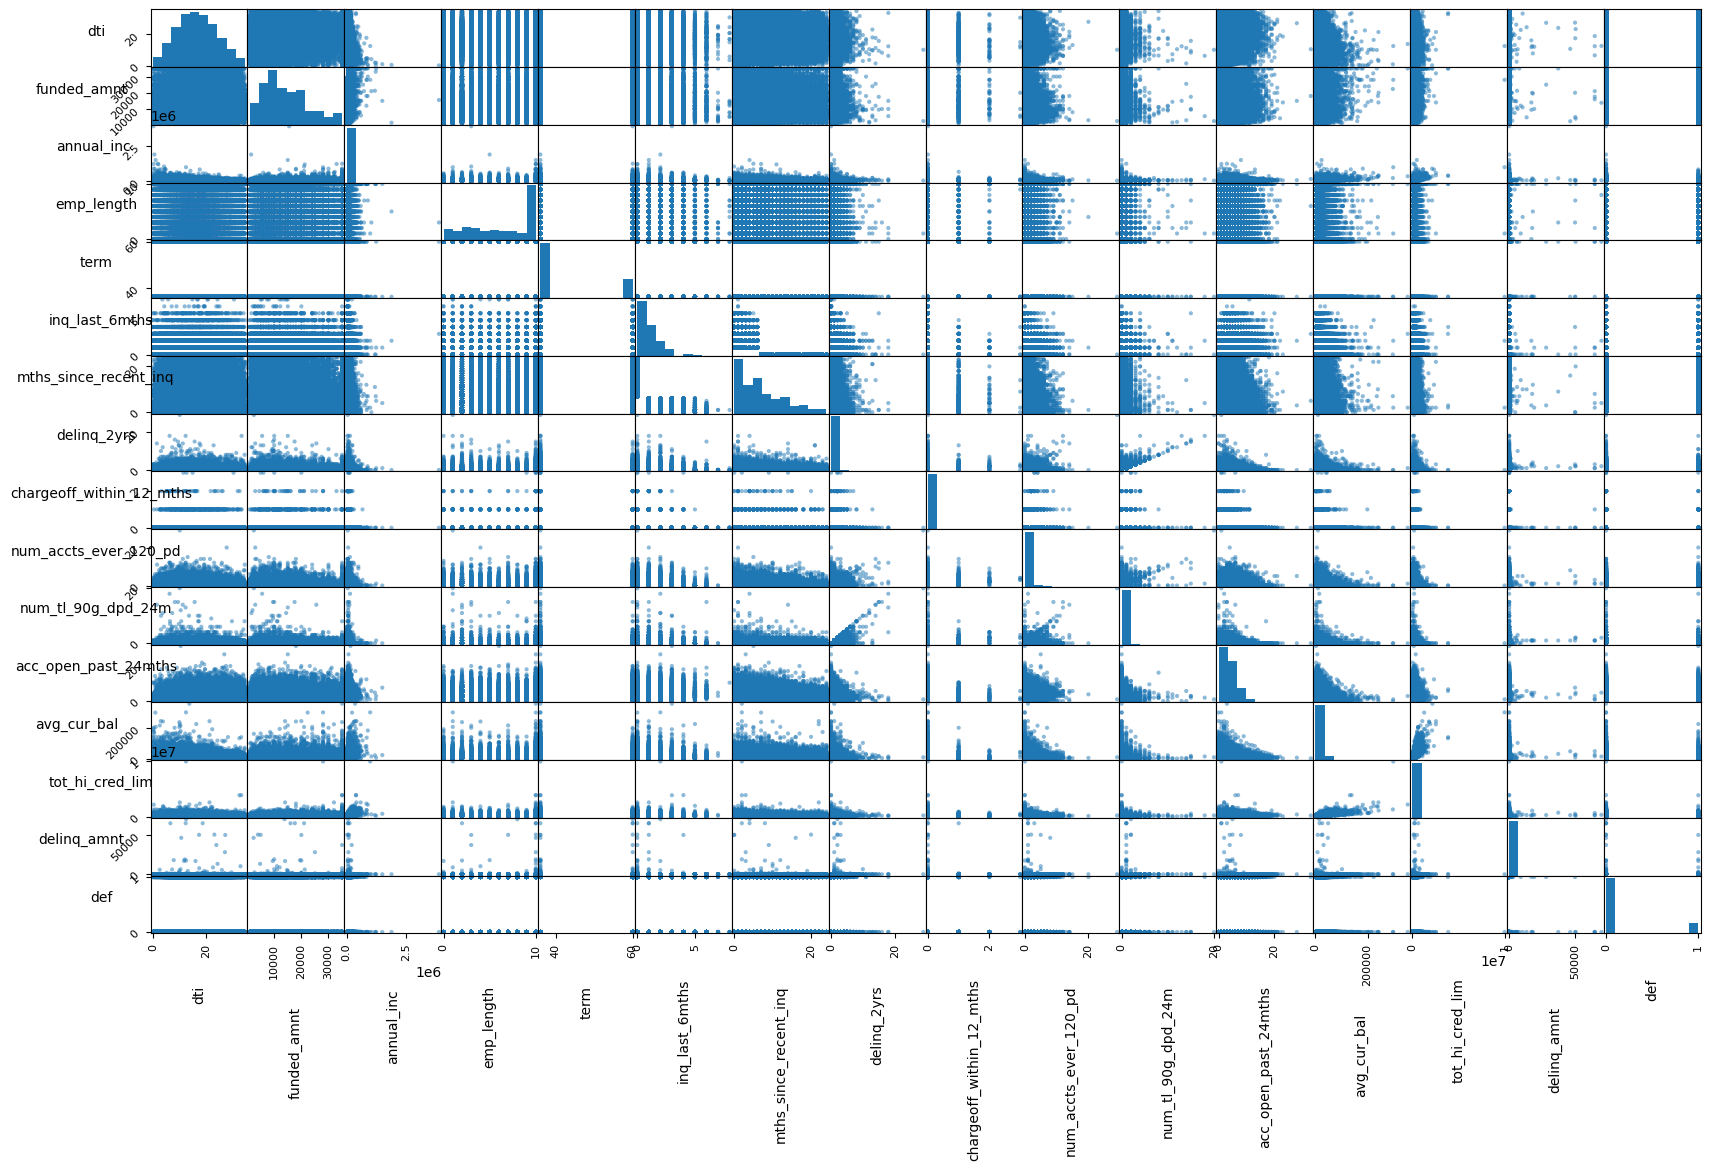

In [ ]:
# Get column names as a list
attributes = numerical_cols
# Create a scatter matrix
scatter_matrix(df[attributes], figsize=(20, 12), diagonal='hist', grid=True, alpha=0.5)
# Rotate attribute names on the x-axis
for i, ax in enumerate(plt.gcf().axes):
    ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.label.set_rotation(90)
    ax.xaxis.labelpad = 20
# Rotate attribute names on the y-axis
for i, ax in enumerate(plt.gcf().axes):
    ax.yaxis.set_tick_params(rotation=45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.labelpad = 20
plt.show()

## Looking at the null values

In [14]:
null_val_sums = df.isnull().sum()
pd.DataFrame({"Column": null_val_sums.index, "Number of Null Values": null_val_sums.values,
             "Proportion": null_val_sums.values / len(df) })

,Column,Number of Null Values,Proportion
0,issue_d,0,0.000000
1,purpose,0,0.000000
2,addr_state,0,0.000000
3,sub_grade,0,0.000000
4,home_ownership,0,0.000000
5,emp_title,3865,0.063186
6,dti,0,0.000000
7,funded_amnt,0,0.000000
8,annual_inc,0,0.000000
9,emp_length,2674,0.043715


In [ ]:
# Calculating the percentage of missing values for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Filtering out columns with a high percentage of missing values (threshold: 20%)
high_missing_columns = missing_percentage[missing_percentage > 20].index.tolist()

# Displaying columns with a high percentage of missing values
print(high_missing_columns, missing_percentage[high_missing_columns])

['mths_since_recent_inq'] mths_since_recent_inq    22.117412
dtype: float64


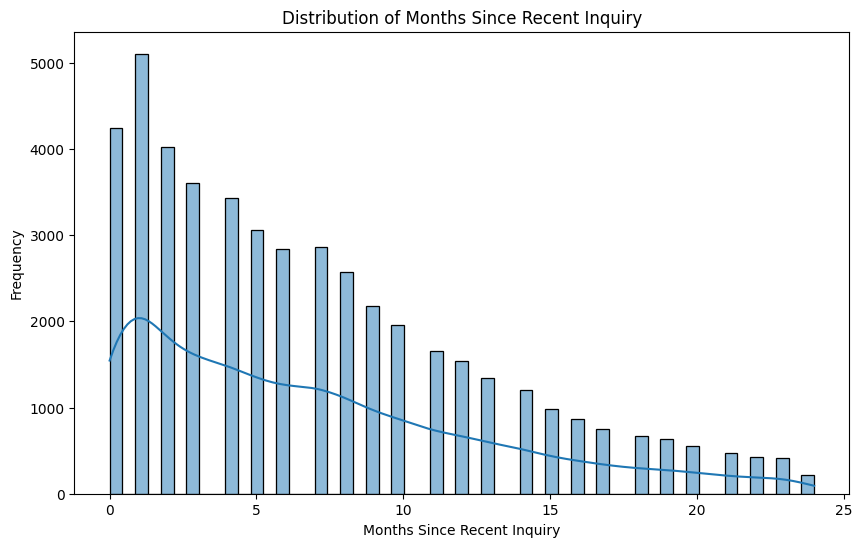

In [ ]:
# Checking the distribution of 'mths_since_recent_inq'
plt.figure(figsize=(10, 6))
sns.histplot(df['mths_since_recent_inq'].dropna(), kde=True)
plt.title('Distribution of Months Since Recent Inquiry')
plt.xlabel('Months Since Recent Inquiry')
plt.ylabel('Frequency')
plt.show()


The distribution of mths_since_recent_inq (Months Since Recent Inquiry) is somewhat skewed, with a concentration of values at lower months. Based on this distribution, imputation using the median might be more appropriate than the mean, as the median is less affected by skewness.
For the other columns with missing values, a similar approach can be applied: evaluate the distribution and decide whether to use mean, median, or mode for imputation.
But to save our time we will use Median value for NA imputation.


## Looking at categorical variables

In [32]:
print(f"1. Number of unique values in 'issue_d': {df['issue_d'].nunique()}")
print(f"2. Number of unique values in 'purpose': {df['purpose'].nunique()}")
print(f"3. Number of unique values in 'addr_state': {df['addr_state'].nunique()}")
print(f"4. Number of unique values in 'sub_grade': {df['sub_grade'].nunique()}")
print(f"5. Number of unique values in 'home_ownership': {df['home_ownership'].nunique()}")
print(f"6. Number of unique values in 'emp_title': {df['emp_title'].nunique()}")
print(f"7. Number of unique values in 'income_category': {df['income_category'].nunique()}")
print(f"8. Number of unique values in 'emp_length_category': {df['emp_length_category'].nunique()}")


1. Number of unique values in 'issue_d': 50
2. Number of unique values in 'purpose': 14
3. Number of unique values in 'addr_state': 47
4. Number of unique values in 'sub_grade': 35
5. Number of unique values in 'home_ownership': 5
6. Number of unique values in 'emp_title': 38576
7. Number of unique values in 'income_category': 4
8. Number of unique values in 'emp_length_category': 4


In [33]:
df['emp_title'].value_counts()

Teacher                               505
Manager                               420
Registered Nurse                      239
RN                                    237
Supervisor                            183
                                     ... 
CBN                                     1
NYC DEPT OF CORRECTIONS                 1
ExploreUSA RV                           1
Brindley Beach Vacations and Sales      1
Admissions Coordinator                  1
Name: emp_title, Length: 38576, dtype: int64

In [20]:
df_2 = df.copy()

In [21]:
# Count the frequency of each job title in 'emp_title'
emp_title_counts = df['emp_title'].value_counts()

# Set a threshold for grouping less frequent job titles
threshold = 20
infrequent_titles = emp_title_counts[emp_title_counts < threshold].index

# Create a mapping for job titles
title_mapping = {title: ('Other' if title in infrequent_titles else title) for title in emp_title_counts.index}

# Apply the mapping to the 'emp_title' column
df_2['emp_title_grouped'] = df_2['emp_title'].map(title_mapping)

# Display the modified 'emp_title_grouped' column (top 10 for demonstration)
print(df_2['emp_title_grouped'].value_counts().head(10))

Other               49291
Teacher               505
Manager               420
Registered Nurse      239
RN                    237
Supervisor            183
Project Manager       167
Sales                 149
Office Manager        142
manager               140
Name: emp_title_grouped, dtype: int64


In [22]:
df_2 = df_2.drop('emp_title', axis=1)
df_2.head()

,issue_d,purpose,addr_state,sub_grade,home_ownership,dti,funded_amnt,annual_inc,emp_length,term,...,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt,def,income_category,emp_length_category,emp_title_grouped
0,4/1/2010,major_purchase,NY,B5,RENT,4.58,6000,60000.0,2.0,36,...,NaN,NaN,NaN,NaN,NaN,0,0,Medium,1-3yrs,Other
1,4/1/2010,debt_consolidation,NY,C1,RENT,13.98,12000,64450.0,3.0,36,...,NaN,NaN,NaN,NaN,NaN,0,0,Medium,1-3yrs,Other
2,4/1/2010,debt_consolidation,VA,B5,MORTGAGE,20.16,24000,90000.0,2.0,36,...,NaN,NaN,NaN,NaN,NaN,0,0,Medium,1-3yrs,Other
3,4/1/2010,debt_consolidation,VA,B5,MORTGAGE,22.05,6000,79500.0,1.0,36,...,NaN,NaN,NaN,NaN,NaN,0,0,Medium,<1yr,Other
4,4/1/2010,home_improvement,WA,A4,RENT,0.94,10000,58608.0,4.0,36,...,NaN,NaN,NaN,NaN,NaN,0,0,Medium,3-5yrs,Other


In [34]:
print(f"1. Number of unique values in 'issue_d': {df_2['issue_d'].nunique()}")
print(f"2. Number of unique values in 'purpose': {df_2['purpose'].nunique()}")
print(f"3. Number of unique values in 'addr_state': {df_2['addr_state'].nunique()}")
print(f"4. Number of unique values in 'sub_grade': {df_2['sub_grade'].nunique()}")
print(f"5. Number of unique values in 'home_ownership': {df_2['home_ownership'].nunique()}")
print(f"6. Number of unique values in 'emp_title_grouped': {df_2['emp_title_grouped'].nunique()}")
print(f"7. Number of unique values in 'income_category': {df['income_category'].nunique()}")
print(f"8. Number of unique values in 'emp_length_category': {df['emp_length_category'].nunique()}")

1. Number of unique values in 'issue_d': 50
2. Number of unique values in 'purpose': 14
3. Number of unique values in 'addr_state': 47
4. Number of unique values in 'sub_grade': 35
5. Number of unique values in 'home_ownership': 5
6. Number of unique values in 'emp_title_grouped': 155
7. Number of unique values in 'income_category': 4
8. Number of unique values in 'emp_length_category': 4


In [35]:
df.head()

,issue_d,purpose,addr_state,sub_grade,home_ownership,emp_title,dti,funded_amnt,annual_inc,emp_length,...,chargeoff_within_12_mths,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt,def,income_category,emp_length_category
0,4/1/2010,major_purchase,NY,B5,RENT,new york HRC,4.58,6000,60000.0,2.0,...,0,NaN,NaN,NaN,NaN,NaN,0,0,Medium,1-3yrs
1,4/1/2010,debt_consolidation,NY,C1,RENT,Harris RF Communications,13.98,12000,64450.0,3.0,...,0,NaN,NaN,NaN,NaN,NaN,0,0,Medium,1-3yrs
2,4/1/2010,debt_consolidation,VA,B5,MORTGAGE,AT&T Government Solutions,20.16,24000,90000.0,2.0,...,0,NaN,NaN,NaN,NaN,NaN,0,0,Medium,1-3yrs
3,4/1/2010,debt_consolidation,VA,B5,MORTGAGE,Information Analysis Inc.,22.05,6000,79500.0,1.0,...,0,NaN,NaN,NaN,NaN,NaN,0,0,Medium,<1yr
4,4/1/2010,home_improvement,WA,A4,RENT,US Government,0.94,10000,58608.0,4.0,...,0,NaN,NaN,NaN,NaN,NaN,0,0,Medium,3-5yrs


### Weight of Evidence (WoE) Encoding:

1. **Purpose and Use Case**:
   - Primarily used in credit scoring and risk modeling.
   - Effective for binary classification problems, especially with a binary target variable.

2. **How It Works**:
   - Transforms a categorical variable into a continuous one by calculating the log of the ratio of the distribution of the target variable.
   - Provides a measure of the "strength" of a grouping in separating good cases from bad cases.

3. **Output**:
   - A single continuous variable for each categorical variable.

4. **Advantages**:
   - Handles categories with different levels of risk naturally.
   - Does not expand the feature space significantly.
   - Captures the relationship between the categorical variable and the binary target.

5. **Disadvantages**:
   - Not suitable for non-binary classification or regression tasks.
   - Can be sensitive to rare events.
   - Requires careful handling of zero-frequency cases.

### One-Hot Encoding:

1. **Purpose and Use Case**:
   - Used in various types of machine learning problems, including regression, classification, etc.
   - Suitable for nominal (non-ordinal) categorical variables.

2. **How It Works**:
   - Creates a new binary (0 or 1) column for each level of the categorical variable.
   - Each observation gets a 1 in the column of its category and 0 in all others.

3. **Output**:
   - Expands the feature space, with one binary feature for each category level.

4. **Advantages**:
   - Simple and effective, widely used and understood.
   - Preserves information about the category.
   - Suitable for non-linear relationships.

5. **Disadvantages**:
   - Can result in a high-dimensional feature space.
   - Not suitable for categorical variables with many levels.

### Choosing Between WoE and One-Hot Encoding:

- **Use WoE** for binary classification, particularly in risk modeling or credit scoring.
- **Use One-Hot Encoding** for general purposes, non-binary classification problems, or regression.

**Thus, we will chose WOE over OneHotEncoding in this project**

### Feature Selection

- Feature selection is deemed unnecessary, primarily because the extensive number of observations (61169) significantly surpasses the relatively modest count of features (21). This substantial difference effectively diminishes the risk of overfitting.

- Furthermore, mostly, the correlation between the features is minimal, indicating an absence of redundant features. In the hypothetical scenario where redundancy exists, we could address it by either removing or reducing it through dimensionality reduction techniques.

Rule of Thumb for Feature Count:
A common rule of thumb in machine learning is the "N:10" or "N:5" rule, where "N" is the number of samples. This rule suggests having at least 10 (or 5 in some versions) times as many observations as features to reduce the risk of overfitting.



# 2. Preparing the Data for the Machine Learning Algorithms

In [39]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Add 'Missing' as a category for each categorical column
for col in categorical_cols:
    if df[col].dtype.name == 'category':
        df[col] = df[col].cat.add_categories('Missing')
    df[col] = df[col].fillna('Missing')

# Recalculate the number of null values
null_val_sums_2 = df.isnull().sum()

# Creating DataFrame to display the information
pd.DataFrame({"Column": null_val_sums_2.index,
              "Number of Null Values": null_val_sums_2.values,
              "Proportion": null_val_sums_2.values / len(df)})


,Column,Number of Null Values,Proportion
0,issue_d,0,0.000000
1,purpose,0,0.000000
2,addr_state,0,0.000000
3,sub_grade,0,0.000000
4,home_ownership,0,0.000000
5,emp_title,0,0.000000
6,dti,0,0.000000
7,funded_amnt,0,0.000000
8,annual_inc,0,0.000000
9,emp_length,2674,0.043715


In [68]:
# Split the data into training and testing sets
X = df.drop(['def'], axis=1)
y = df['def'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Automatically get the list of categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute with median for numerical columns
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('woe', WOEEncoder(cols=categorical_cols))  # WOE encoding for categorical columns
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a final pipeline that includes the preprocessing steps
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the training data
X_train_transformed_numpy = pipeline.fit_transform(X_train, y_train)

# Transform the testing data (do not fit again)
X_test_transformed_numpy = pipeline.transform(X_test)


# Create DataFrames from the transformed NumPy arrays
X_train_scaled = pd.DataFrame(X_train_transformed_numpy, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_transformed_numpy, columns=X_test.columns)


In [41]:
X_train_scaled.head()

,issue_d,purpose,addr_state,sub_grade,home_ownership,emp_title,dti,funded_amnt,annual_inc,emp_length,...,delinq_2yrs,chargeoff_within_12_mths,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt,income_category,emp_length_category
0,-1.329164,-0.587671,-0.348496,1.130326,-0.595359,1.088608,-0.917011,-0.339011,-0.069496,-0.322044,...,-0.833353,-0.017991,-0.064617,0.067326,0.033129,0.180002,0.116726,0.0000,-0.046500,-0.019250
1,-1.870414,-0.935818,-0.388202,-0.573957,-0.595359,1.088608,-0.144807,-0.339011,-0.069496,-0.322044,...,-0.290734,-0.017991,-0.104564,-0.188905,0.062883,0.100880,-0.108071,-0.5382,-0.046500,0.021734
2,0.855732,0.795754,0.086759,1.130326,1.679659,2.951591,-1.110062,-0.339011,-0.069496,-0.322044,...,0.045936,-0.017991,-0.019748,0.067326,0.065201,0.298264,-0.108071,0.0000,-0.046500,-0.019250
3,0.307850,2.191394,2.364488,0.278185,-0.595359,1.088608,-1.110062,-0.339011,-0.069496,-0.322044,...,1.632035,-0.017991,0.055557,0.067326,0.031636,0.512642,-0.108071,0.0000,-0.394664,-0.019250
4,-1.196505,-0.996896,-0.689061,0.846279,-0.595359,-0.774374,0.820448,-0.339011,-0.069496,-0.322044,...,-0.162515,-0.017991,-0.010878,0.146137,0.033129,0.416119,0.116726,0.0000,0.192467,-0.019250


In [42]:
X_test_scaled.head()

,issue_d,purpose,addr_state,sub_grade,home_ownership,emp_title,dti,funded_amnt,annual_inc,emp_length,...,delinq_2yrs,chargeoff_within_12_mths,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt,income_category,emp_length_category
0,0.070390,0.713298,2.235721,0.278185,-0.595359,0.157117,-0.917011,-0.339011,-0.069496,-0.322044,...,-0.027970,-0.017991,-0.022635,-0.213830,-0.531231,-0.260628,0.116726,0.000000,-0.394664,-0.019250
1,-1.459170,-1.119053,-0.410561,1.130326,-0.595359,-0.774374,0.820448,-0.339011,-0.069496,-0.322044,...,-0.924905,-0.017991,-0.050660,0.146137,0.033129,-0.043252,0.053938,0.359742,-0.046500,-0.019250
2,-1.100991,-0.605995,-0.649275,-0.858004,-0.595359,0.157117,-0.144807,-0.339011,-0.069496,-0.322044,...,-0.290734,-0.017991,-0.107417,0.067326,-0.075576,-1.071700,0.116726,0.209015,0.192467,-0.031582
3,-0.135232,-0.263956,-0.151955,-0.858004,1.679659,0.157117,-0.917011,-0.339011,-0.069496,-0.322044,...,0.336320,-0.017991,0.009835,0.067326,-0.072737,-0.328277,-0.108071,0.000000,-0.046500,-0.031582
4,0.427243,0.175808,-0.589597,1.130326,-0.595359,-0.774374,-0.144807,-0.339011,-0.069496,-0.322044,...,-0.290734,-0.017991,0.031238,0.067326,0.033129,-1.071700,-0.108071,0.560413,0.192467,-0.019250


# 3. Training, validating models. Hyperparameter Tuniing

## Selecting a Cost Function
In machine learning, a cost function, also known as a loss or objective function, quantifies the difference between predicted and actual values. The goal is to minimize this function during the training process. The choice of a suitable cost function depends on the type of problem (e.g., regression, classification) and desired model behavior. Minimizing the cost function leads to the model learning optimal parameters and improving its predictive accuracy. Common examples include mean squared error for regression tasks and cross-entropy for classification problems.

Cross-entropy, often used as a cost function in machine learning, measures the dissimilarity between predicted and actual probability distributions. In classification tasks, it quantifies how well the predicted probabilities align with the true class labels. Minimizing cross-entropy during training improves the accuracy of the model's predictions. It is a fundamental concept in information theory and is widely applied, especially in scenarios involving categorical outcomes.

Given that we're dealing with a supervised classification problem involving two classes, we'll employ binary classification log loss. This metric calculates the cross-entropy between the actual labels and the predictions generated by the model.

$$\mathrm{log loss}= -\frac{1}{N}\sum_{i=1}^N  \left[y_{i} \log(p_i)+(1-y_i)\log(1-p_i)\right]$$

### Model Training Process
The logistic regression model will undergo training across each of the five k-fold cross-validation splits. During each iteration, the model is trained on four-fifths of the training set, and its performance is assessed on the fifth slice reserved for validation.

Throughout the iterative training and evaluation process, the cost function will be computed for both the training subset (i.e., the four-fifths slice of the original training set) and the validation subset (i.e., the one-fifth slice of the original training set).

Additionally, predictions will be stored for each of the five cross-validation sets. By the conclusion of the fifth iteration, a set of predictions for the entire training dataset will have been accumulated.

## Model 1: Logistic Regression
The model:

$$p(x) = \frac{e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots }}{1 + e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots }} = sigmoid(\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots)$$

- We will opt for the default L2 penalty rather than L1. L2 demonstrates lower sensitivity to outliers, assigning non-zero weights to nearly all features and yielding a more stable solution.

- In contrast, L1 assigns substantial weights to crucial features while assigning close-to-zero weights to others, essentially conducting feature selection during the algorithm's training.

- **The regularization strength, denoted as \(C\), plays a crucial role in addressing overfitting by penalizing complexity. A higher \(C\) implies a stronger penalty, guiding the machine learning algorithm towards simpler models.**

- Given the highly imbalanced nature of the dataset, with only 6.68 % of observations labeled as default, we aim to emphasize learning from these during the algorithm's training.

- To achieve this, we will set the class_weight to *balanced*. This instructs the algorithm to assign greater weight to positive labels (Default) and lower weight to negative labels (Non-default), proportional to their respective frequencies, effectively focusing more on the rare positive cases.

Advantages:

straightforward
easily understandable
facilitates inference

Disadvantages:

relies on assumptions inherent to logistic regression
Hyperparameters:

C: The inverse of the regularization strength for $l_1$ or $l_2$ regularization; smaller values indicate stronger regularization
Penalty: The norm utilized in penalization (e.g., $l_1$, $l_2$, or a combination)

In [ ]:
LR_model = LogisticRegression(C=0.01)
LR_model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.01)

In [ ]:
predicted_probabilities = LR_model.predict_proba(X_test_scaled)[:, 1]
predicted_probabilities

array([0.05261935, 0.13230018, 0.07751043, ..., 0.16179638, 0.06731672,
       0.21826046])

In [ ]:
y_pred = LR_model.predict(X_test_scaled)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

### Assessing the Outcomes
In most cases (though exceptions exist), the log loss observed during training tends to be lower than that during cross-validation. This discrepancy arises because the machine learning algorithm directly learns from the training data, leading to better performance (i.e., lower log loss) on the training set compared to the cross-validation set.

It's crucial to note that the cross-validation set comprises transactions deliberately withheld from the training process.

Across all five runs, the log losses for both training and cross-validation sets exhibit similarity.

The logistic regression model demonstrates no significant overfitting. In cases of severe overfitting, one would observe a low training log loss accompanied by a relatively high cross-validation log loss.

![image.png](https://glassboxmedicine.files.wordpress.com/2019/02/confusion-matrix.png?w=816)


**Accuracy**: $(TP + TN)/(TP + TN + FP + FN)$ -- the fraction of predictions our model got right

**Precision**: $TP/ (TP + FP)$ -- What proportion of positive identifications was actually correct?

**Recall**: $TP / (TP + FN)$ -- What proportion of actual positives was identified correctly?


For Credit scoring, in the setting when 1 means Default, Recall metric is arguably more importan. As for a lender correctly predicting default cases seems more important.

In [ ]:
score = roc_auc_score(y_test, predicted_probabilities)
print('ROC AUC {:.4f}'.format(score))

ROC AUC 0.6831


In [ ]:
scores = predicted_probabilities

In [ ]:
a = confusion_matrix(y_test, y_pred)
a

array([[10224,    71],
       [ 1923,    16]])

In [ ]:
print('accuracy = {:.3f}'.format((a[0,0] + a[1,1]) / a.sum()))
print('accuracy_score(yval, y_pred) = {:.3f}'.format(accuracy_score(y_test, y_pred)))

accuracy = 0.837
accuracy_score(yval, y_pred) = 0.837


In [ ]:
# As a rule of thumb, we employ the threshhold level that is approximately equal to the mean level of our target variable. Approximatey, 6.68% in pur case.
# In order to make Recall higher we will set up the threshhold value to relatively low level.
threshold = 0.1595906423188216

In [ ]:
tr = np.linspace(0, 1, 100)

p = np.zeros_like(tr)
r = np.zeros_like(tr)
f = np.zeros_like(tr)

for k, x in enumerate(tr):

    y_pred = scores >= x

    p[k] = precision_score(y_test, y_pred)
    r[k] = recall_score(y_test, y_pred)
    f[k] = f1_score(y_test, y_pred)

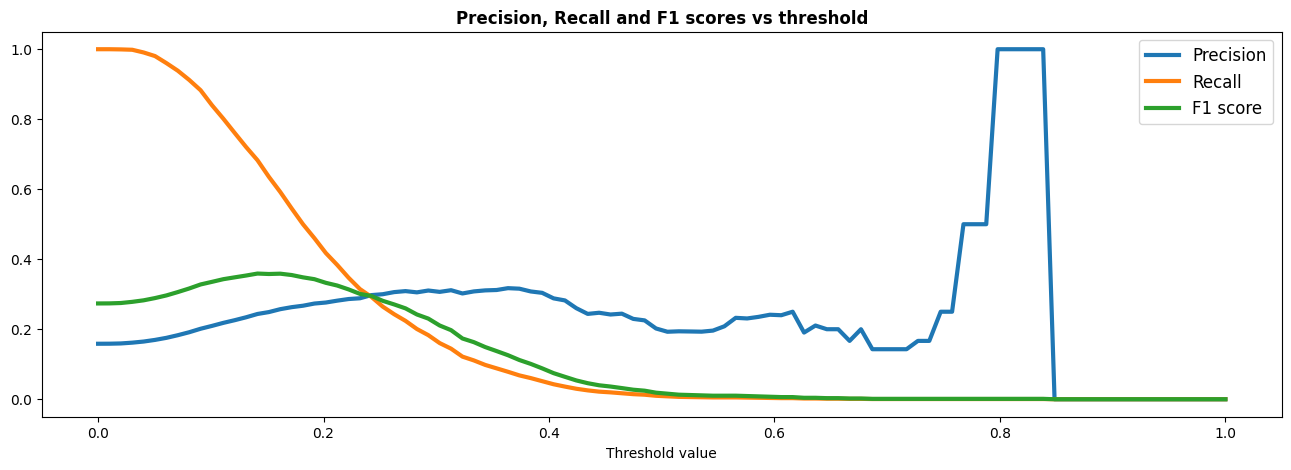

In [ ]:
fig = plt.figure(figsize=(16, 5))

plt.plot(tr, p, linewidth=3)
plt.plot(tr, r, linewidth=3)
plt.plot(tr, f, linewidth=3)

plt.title("Precision, Recall and F1 scores vs threshold", weight="bold")

plt.xlabel("Threshold value")

plt.legend(['Precision', 'Recall', 'F1 score'], fontsize=12)

plt.show()

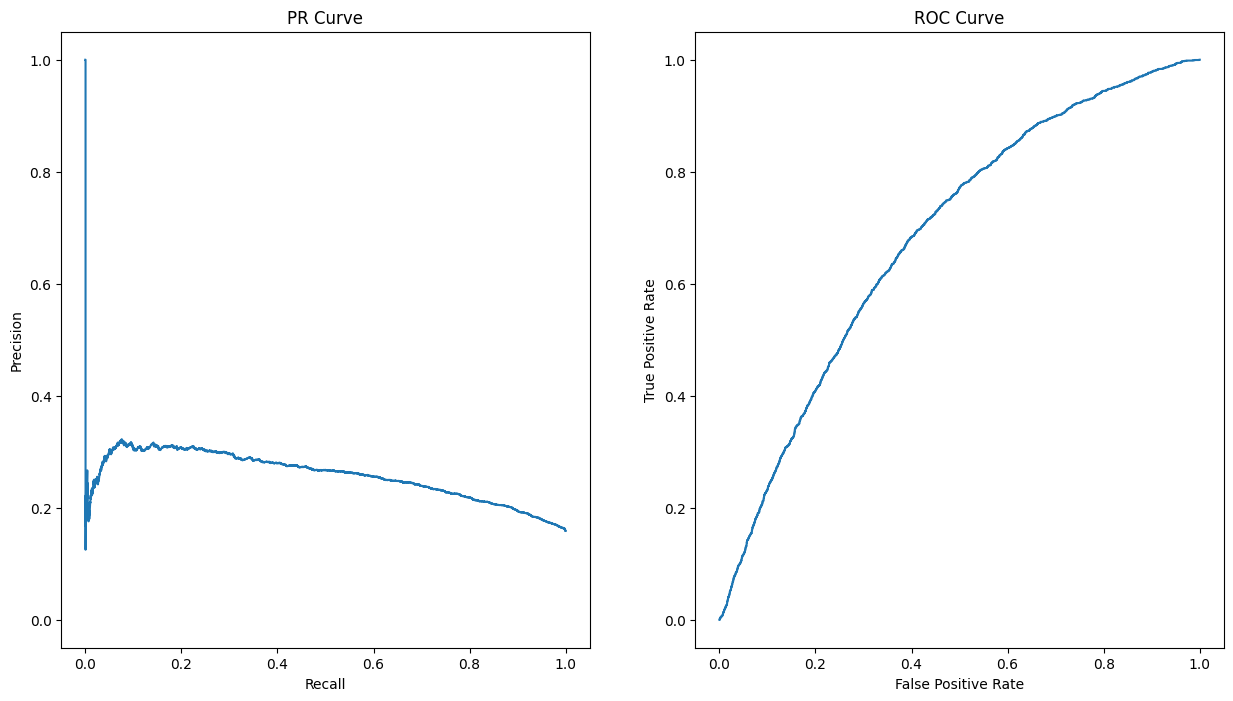

In [ ]:
p, r, _ = precision_recall_curve(y_test, scores)
tpr, fpr, _ = roc_curve(y_test, scores)

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

ax1.plot(r,p)
ax2.plot(tpr,fpr)

plt.show()

### Cross-Validation

### Generating k-Fold Cross-Validation Sets
K-fold cross-validation is a technique in machine learning where the dataset is divided into k subsets. The model is trained and validated k times, each time using a different fold for validation and the remaining folds for training. It provides a more robust estimate of the model's performance, helps identify potential issues like overfitting, and is commonly used for parameter tuning. The final performance metric is often the average across all k runs. This approach is beneficial for making the most effective use of available data and reducing the variance in performance estimation.


In [ ]:
cv = StratifiedKFold(n_splits=5)

LR_model = LogisticRegression(C=0.01)

scores = cross_val_score(LR_model, X_train_scaled, y_train, scoring='roc_auc')

print('Scores on CV folds:', scores, '\n')
print('Average score on CV folds: {:.4f}'.format(np.mean(scores)))
print('Std of score on CV folds: {:.4f}'.format(np.std(scores)))

Scores on CV folds: [0.7061003  0.71953635 0.71535419 0.71454105 0.71130754] 

Average score on CV folds: 0.7134
Std of score on CV folds: 0.0045


## Hyperparameter Tuning

Finding the best hyperparameter for C in logreg using **Grid Search** and  using roc-auc scoring

In [ ]:
params = {
    'C': np.logspace(-3, 0, 20),
}

LR_model = LogisticRegression()

GS_LR = GridSearchCV(cv=cv, estimator=LR_model, param_grid=params, scoring='roc_auc')

GS_LR.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
       0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
       0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
       0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ])},
             scoring='roc_auc')

In [ ]:
print('Best C {:.3f}'.format(GS_LR.best_params_['C']))
print('Best ROC AUC {:.4f}'.format(GS_LR.best_score_))

Best C 1.000
Best ROC AUC 0.7158


### Plotting mean and std of scores after CV

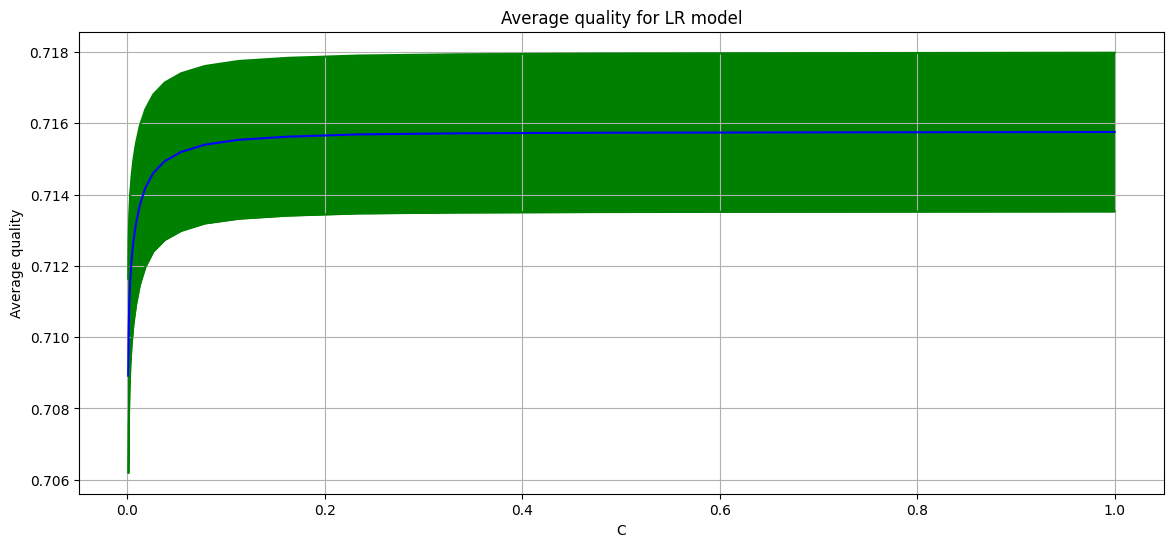

In [ ]:
means = GS_LR.cv_results_['mean_test_score']
stds = GS_LR.cv_results_['std_test_score']
error = 0.5 * stds

plt.figure(figsize=(14, 6))
plt.plot(params['C'], means, color = 'blue')
plt.plot(params['C'], means - error, color = 'green')
plt.plot(params['C'], means + error, color = 'green')
plt.fill_between(params['C'], means - error, means + error, color = 'green')
plt.xlabel('C')
plt.ylabel('Average quality')
plt.title('Average quality for LR model')
plt.grid()
plt.show()

.best_estimator_: This attribute of the GridSearchCV or RandomizedSearchCV object contains the best-performing model (estimator) that was found during the search. It represents the model configuration with the best combination of hyperparameters based on the specified scoring metric.

In [ ]:
best_model = GS_LR.best_estimator_

In [ ]:
best_model.predict(X_test_scaled)

array([0, 0, 0, ..., 0, 0, 0])

## Model 2: Decision Tree Classifier.

A decision tree resembles a flowchart with a tree-like structure, where every internal node represents a test or condition on a particular attribute. The branches emerging from these nodes indicate the possible outcomes of the test (like True or False), and each leaf node, or terminal node, is assigned a class label. This structure is used to make splits in the dataset to distinguish between different classes. When a new data point is introduced, the decision tree classifies it into one of these classes based on the paths and conditions defined in the tree. The boundaries for classification in this model are represented by horizontal and vertical lines.

**Pros:**
1. **Interpretability**: Decision trees are straightforward and easy to understand, making them highly interpretable.
2. **No Need for Feature Scaling**: They don't require feature scaling like normalization or standardization. (you can pass scaled data to a Decision Tree Classifier, but in most cases, it's not necessary, and it won't impact the performance of the model)
3. **Flexibility**: Capable of handling both linear and non-linear problems effectively.

**Cons:**
1. **Performance with Small Datasets**: Tend to underperform on very small datasets.
2. **Overfitting Risks**: Prone to overfitting, especially with complex trees.

### Key Hyperparameters
1. **Criterion**: Choice between 'gini' or 'entropy' for measuring the quality of a split.
2. **Max Depth (`max_depth`)**: The maximum depth of the tree.
3. **Min Samples Split (`min_samples_split`)**: The minimum number of samples required to split an internal node.
4. **Min Samples Leaf (`min_samples_leaf`)**: The minimum number of samples required to be at a leaf node.


In [ ]:
dtc = DecisionTreeClassifier(random_state=123)

dtc.fit(X=X_train_scaled, y=y_train)

DecisionTreeClassifier(random_state=123)

In [ ]:
score = dtc.score(X_test_scaled, y_test)
print('ROC AUC {:.3f}'.format(score))

ROC AUC 0.738


A decision tree can achieve zero error on a given training sample if it's built consistently. This is because in the feature space, each data point can be encapsulated within an n-dimensional cube that doesn't encompass any other points. A tree can be meticulously structured to fit each of these cubes perfectly. **But, this scenario leads to overfitting.**

## Criteria for Early Stopping in Decision Trees to Prevent Overfitting

1. **Maximum Tree Depth (`max_depth`)**: Restricts the tree to a certain depth to reduce complexity.

2. **Minimum Samples Split (`min_samples_split`)**: Defines the minimum number of samples required to split an internal node. Helps in preventing overly complex trees.

3. **Minimum Samples Leaf (`min_samples_leaf`)**: Sets the minimum number of samples required at a leaf node, avoiding leaves with very few samples.

4. **Maximum Number of Leaf Nodes (`max_leaf_nodes`)**: Controls the size of the tree by limiting the number of leaf nodes.

5. **Maximum Features (`max_features`)**: Limits the number of features considered for each split, reducing the risk of fitting to noise.

6. **Pruning**: Involves removing less powerful branches post full tree development, such as using cost-complexity pruning (`ccp_alpha`).

7. **Cross-Validation**: Utilizes validation data to evaluate the tree's performance on unseen data, aiding in detecting overfitting.

8. **Early Stopping Criteria**: Implementation of a stopping rule based on the improvement threshold of the model's performance.

**These techniques, when combined and tuned through cross-validation, aid in effectively mitigating overfitting in decision trees.**


### Cross Validation

In [ ]:
cv_scores = cross_val_score(dtc, X_train_scaled, y_train, cv=5, scoring='roc_auc')
# Print the ROC AUC scores for each fold and their mean
print("ROC AUC scores for each fold:", cv_scores)
print("Average ROC AUC score:", cv_scores.mean())

ROC AUC scores for each fold: [0.55693453 0.54945811 0.56237294 0.56617328 0.55604487]
Average ROC AUC score: 0.5581967473256837


### Analysis of ROC AUC Scores

The difference in ROC AUC scores observed between using cross-validation and a single train-test split can be attributed to several factors:

1. **Overfitting in Single Split**: The higher ROC AUC score obtained without cross-validation might indicate overfitting to the specific characteristics of the train-test split. This suggests that the model may have learned details specific to the test data that do not generalize well.

2. **Robustness of Cross-Validation**: Cross-validation offers a more robust estimate of model performance. By training and testing the model on different data subsets, cross-validation provides a more reliable assessment of the model's ability to generalize. This is particularly true for smaller or imbalanced datasets. The average ROC AUC score across folds is generally a more realistic measure of model performance on unseen data.

3. **Dataset Variability**: The varying characteristics of different folds in cross-validation can lead to differences in model performance. This effect is more pronounced in datasets that are small, imbalanced, or noisy.

4. **Data Distribution Differences**: If the distribution of the training set significantly differs from the test set, the model might perform unusually well or poorly on the test set. Cross-validation helps mitigate this by validating the model on multiple data subsets.

5. **Randomness and Model Complexity**: Random Forest models are influenced by the randomness in tree construction. More complex models are more likely to capture noise, leading to optimistically high scores on specific test sets.

**In summary, while single-split ROC AUC scores can be impressive, they might not accurately reflect the model's ability to generalize. The more conservative estimates from cross-validation are usually more reliable and indicative of the model's performance on unseen data.**


### HP tuning

The grid search will explore different combinations of the parameters to find the one that yields the best ROC AUC score.
This approach hepls us to determine not only the depth and complexity of the tree but also to find out how many features should be considered at each split for optimal performance.

In [ ]:
# Defining the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2', 0.5, 0.7]
}

# Setting up the Grid Search
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='roc_auc', n_jobs=1)

# Fitting the Grid Search model
grid_search.fit(X_train_scaled, y_train)

# Printing the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)

Best parameters: {'max_depth': 5, 'max_features': 0.7, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best ROC AUC score: 0.6967521178743834


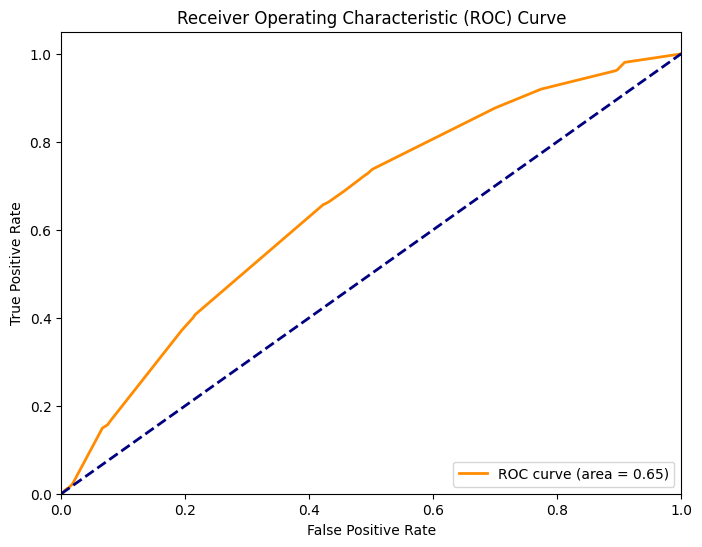

In [ ]:
# Get the best estimator
best_model = grid_search.best_estimator_

# Predict probabilities on the test set
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Model 3: Random Forset

### Random Forest Classifier

**Pros:**
- **Better Performance**: Generally provides more accurate predictions than a single decision tree.
- **Overfitting Reduction**: Less prone to overfitting compared to a single decision tree due to averaging of multiple trees.
- **Handles Unbalanced Data**: Works well with unbalanced and missing data.
- **Feature Importance**: Provides insights into feature importance, helpful for feature selection.

**Cons:**
- **Complexity and Size**: More complex and requires more computational resources and memory.
- **Model Interpretability**: Less interpretable than a single decision tree due to the complexity of multiple trees.
- **Training Time**: Longer training time because of multiple trees.
- **Performance with Noisy Data**: Can overfit on certain noisy classification/regression tasks.

Random Forest classifiers generally outperform single Decision Tree classifiers in terms of accuracy and are less prone to overfitting, but they lose out in terms of simplicity and interpretability. The choice between the two depends on the specific requirements of the problem, such as the need for accuracy versus the need for a clear, interpretable model.


Random Forest is based on creating $B$ bootstrap samples (sampling with replacement) from our training data.
For each sample, construct a deep decision tree, resulting in $B$ trees, denoted as $f_1, f_2, \dots, f_B$.
When evaluating splits, randomly select $m$ features from the total $p$ features, where $m < p$.

We shpuld choose the optimal split from these $m$ features. This strategy reduces the correlation between trees.
For predictions, we should calculate the average of all tree predictions: $\hat{y} = 1/B \sum_{i=0}^{B} f_i(x)$.

Key parameters to adjust in this model include:

- n_estimators - the count of trees,
- max_samples - the size of each bootstrapped training set,
- max_features - the number of features to consider for splits,
- max_depth - the maximum depth of each tree.

It's often recommended to leave max_depth unlimited for comprehensive learning, but setting a limit can speed up processing on large datasets or reduce noise impact.
The standard practice is to set n_estimators first, then adjust the other parameters. The second most crucial parameter is max_features, which should be tuned with a fixed n_estimators.

In [ ]:
# Creating the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=123)

# Training the model
rf_model.fit(X_train_scaled, y_train)

# Making predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


In [ ]:
print(accuracy)
print(conf_matrix)
print(class_report)

0.8347229033840118
[[10184   111]
 [ 1911    28]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     10295
           1       0.20      0.01      0.03      1939

    accuracy                           0.83     12234
   macro avg       0.52      0.50      0.47     12234
weighted avg       0.74      0.83      0.77     12234



In [ ]:
score = rf_model.score(X_test_scaled, y_test)
print('ROC AUC {:.3f}'.format(score))

ROC AUC 0.835


### Cross Validation

In [ ]:
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
# Print the ROC AUC scores for each fold and their mean
print("ROC AUC scores for each fold:", cv_scores)
print("Average ROC AUC score:", cv_scores.mean())

ROC AUC scores for each fold: [0.69910889 0.70021251 0.71231707 0.71235515 0.70462175]
Average ROC AUC score: 0.7057230726243157


### HP Tuning

Let's switch to Randomized Search procedure in order to increase the speed of computations.
### Randomized Search

- **Sampling**: Randomized Search randomly selects a fixed number of combinations of hyperparameters to evaluate. This number is specified by the user and is independent of the size of the parameter grid.
- **Faster for Large Grids**: It can provide substantial time savings over Grid Search when the number of possible hyperparameter combinations is very high.
- **Probability-Based**: There's a chance that Randomized Search might miss the absolute best combination, especially if the number of iterations is too low. However, in practice, it often finds a combination that is close to the best or good enough, particularly in cases where the hyperparameter response surface is smooth.
- **Efficiency**: For many practical purposes, Randomized Search finds a sufficiently optimal solution much faster than Grid Search because it doesn't need to explore every single combination.

### Speed Comparison

- **Theoretical Speedup**: If we have a grid with 1000 potential combinations and we choose to run Randomized Search with 100 iterations, Randomized Search could theoretically be about 10 times faster. However, this doesn't always linearly translate to real-world speedup due to various factors like model complexity and parallel processing capabilities.
- **Practical Considerations**: In many cases, especially with complex models and large datasets, the time savings can be substantial enough to make Randomized Search the preferred choice, particularly when a slightly suboptimal solution is acceptable.



In [ ]:
param_dist = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 5),
    'max_features': [None, 'auto', 'sqrt', 'log2', 0.5, 0.7]
}

# Set up the Randomized Search
n_iter_search = 20  # Number of parameter settings that are sampled
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, scoring='roc_auc', n_jobs=1)

# Fit the Randomized Search model
random_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best ROC AUC score
print("Best parameters:", random_search.best_params_)
print("Best ROC AUC score:", random_search.best_score_)


Best parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 7}
Best ROC AUC score: 0.7298004017926777


## Model 4: k Nearest Neighbours (kNN)

### k-Nearest Neighbors (kNN) Summary

k-Nearest Neighbors (kNN) is a fundamental algorithm in machine learning, used for both classification and regression tasks. Below is an overview of its key aspects:

#### Concept
- **Proximity-Based**: Assumes similar data points are close to each other.
- **Instance-Based Learning**: Retains the training dataset for making predictions.

#### Working
- **Classification**: Assigns a class based on the majority class of the 'k' nearest neighbors.
- **Regression**: Predicts a value based on the average of the values of the 'k' nearest neighbors.
- **Distance Metric**: Utilizes metrics like Euclidean or Manhattan distance to find closest neighbors.

#### Hyperparameters
- **Number of Neighbors (k)**: Crucial parameter influencing the model's sensitivity to noise and computation cost.
- **Distance Metric**: Choice of metric (Euclidean, Manhattan, Minkowski, etc.) can impact performance.

#### Features
- **No Training Phase**: Does not learn a function but stores the dataset.
- **Lazy Learning**: Approximates the function locally, with computation deferred until evaluation.

#### Advantages
- **Simple and Versatile**: Easy to implement, suitable for classification and regression.
- **Effective with Sufficient Data**: Performs well with large, representative datasets.

#### Disadvantages
- **Scalability and Efficiency**: Inefficient with large datasets due to storage and computation needs.
- **Curse of Dimensionality**: Performance degrades with increasing number of features.
- **Sensitivity to Features**: Requires careful feature selection or dimensionality reduction.

#### Applications
- Used in recommender systems, image classification, pattern recognition, and more. Its effectiveness depends on data quality, 'k' value, and distance metric choice.


In [ ]:
kNN_model = KNeighborsClassifier()
cv_scores = cross_val_score(kNN_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
# Print the ROC AUC scores for each fold and their mean
print("ROC AUC scores for each fold:", cv_scores)
print("Average ROC AUC score:", cv_scores.mean())

ROC AUC scores for each fold: [0.595236   0.60846864 0.59902685 0.61113466 0.59656528]
Average ROC AUC score: 0.6020862870911932


#### CV and HP tuning

In [ ]:
cv = StratifiedKFold(n_splits=5)

kNN_model = KNeighborsClassifier()

# Define the hyperparameter distribution
params = {
    'n_neighbors': sp_randint(1, 100)
}

# Set up Randomized Search
n_iter_search = 20
RS_kNN = RandomizedSearchCV(
    kNN_model,
    param_distributions=params,
    n_iter=n_iter_search,
    cv=cv,
    scoring='roc_auc',
    random_state=42,
    n_jobs=1
)

# Fit the Randomized Search model
RS_kNN.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", RS_kNN.best_params_)
print("Best ROC AUC Score:", RS_kNN.best_score_)

Best Parameters: {'n_neighbors': 93}
Best ROC AUC Score: 0.6855055533988963


## Model 5: Blending. Voting Classifier

A Voting Classifier is an ensemble machine learning model that combines the predictions from multiple other models. It is typically used to improve the overall performance by leveraging the strengths of various base models.

#### Concept
- **Ensemble Approach**: Combines the decisions from multiple models to make a final prediction.
- **Types of Voting**:
  - **Hard Voting**: Uses the mode of the predictions (majority vote) from the base models.
  - **Soft Voting**: Predicts the class label based on the average of probabilities given by the base models.

#### Working
- **Combining Models**: Incorporates diverse models, often with different algorithms, to make a collective decision.
- **Final Decision Rule**: Depends on the voting strategy (hard or soft).

#### Advantages
- **Improved Performance**: Often achieves higher performance than individual models alone.
- **Reduced Overfitting**: By averaging out biases, it reduces the likelihood of overfitting.

#### Disadvantages
- **Complexity**: More complex to implement and understand compared to a single model.
- **Computationally Intensive**: Requires training multiple models, which can be resource-intensive.

#### Applications
- Commonly used in competitions and practical applications where performance improvement is critical.
- Effective in scenarios where individual models have different strengths and weaknesses.

#### Considerations
- **Model Diversity**: It is crucial to combine models that are diverse and have different error patterns.
- **Tuning**: Requires careful tuning of the base models and the selection of an appropriate voting strategy.


In [ ]:
# pass our models to VotingClassifier

kNN_model = KNeighborsClassifier(n_neighbors=RS_kNN.best_params_['n_neighbors'])

LR_model = LogisticRegression(C=GS_LR.best_params_['C'])

VC = VotingClassifier([('kNN', kNN_model), ('LR', LR_model)], voting='soft')

#### CV and HP tuning

In [ ]:
cv_scores = cross_val_score(VC, X_train_scaled, y_train, cv=5, scoring='roc_auc')
# Print the ROC AUC scores for each fold and their mean
print("ROC AUC scores for each fold:", cv_scores)
print("Average ROC AUC score:", cv_scores.mean())

ROC AUC scores for each fold: [0.70803471 0.71803085 0.71498194 0.71401298 0.7105917 ]
Average ROC AUC score: 0.7131304346631137


In [ ]:
# Define the distribution for weights
def generate_random_weights():
    i = np.random.uniform(0, 1)
    return [i, 1 - i]

# Set up Randomized Search
n_iter_search = 20
RS_VC = RandomizedSearchCV(
    estimator=VC,
    param_distributions={
        'weights': [generate_random_weights() for _ in range(200)]
    },
    n_iter=n_iter_search,
    cv=cv,
    scoring='roc_auc',
    random_state=123,
    n_jobs=1
)

# Fit the Randomized Search model
RS_VC.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", RS_VC.best_params_)
print("Best ROC AUC Score:", RS_VC.best_score_)

Best Parameters: {'weights': [0.1747179771935461, 0.8252820228064539]}
Best ROC AUC Score: 0.7166709524501609


## Model 6: LightGBM  (Light Gradient Boosting Machine)

### LightGBM and XGBoost: Overview of Gradient Boosting Frameworks

#### LightGBM (Light Gradient Boosting Machine)
- **Developed By**: Microsoft.

**Key Features**:
- **Efficient Handling of Large Data**: Utilizes a histogram-based algorithm, enhancing speed and efficiency, especially with large datasets.
- **Lower Memory Usage**: More memory-efficient compared to traditional gradient boosting frameworks.
- **Gradient-based One-Side Sampling (GOSS)**: A feature sampling method focusing on the most informative instances and minimizing the influence of less significant ones.
- **Exclusive Feature Bundling (EFB)**: Reduces the number of features by bundling mutually exclusive features, with minimal information loss.
- **Support for Categorical Features**: Natively handles categorical features, eliminating the need for one-hot encoding.

**Usage**:
- Ideal for handling large datasets efficiently and speedily, often chosen in scenarios with limited computational resources.

#### XGBoost (eXtreme Gradient Boosting)
- **Developed By**: Tianqi Chen, as part of the Distributed Machine Learning Toolkit (DMLC) project.

**Key Features**:
- **High Performance and Scalability**: Renowned for its robust performance and scalability.
- **Regularization**: Incorporates L1 and L2 regularization to help reduce overfitting.
- **Handling of Missing Values**: Effectively manages missing data natively.
- **Tree Pruning**: Employs a depth-first approach for tree pruning, diverging from traditional methods.
- **Cross-validation**: Features an inbuilt cross-validation mechanism.

**Usage**:
- Extremely versatile, suitable for a broad spectrum of data science challenges and competitions, known for its high-performance model output.


### Differences from Random Forest

- **Model Building**:
  - Random Forest builds trees independently.
  - LightGBM and XGBoost build trees sequentially.

- **Bias-Variance Trade-off**:
  - Random Forest reduces variance without increasing bias.
  - Gradient boosting methods (LightGBM, XGBoost) can reduce bias but may increase variance.

- **Performance**:
  - LightGBM and XGBoost often outperform Random Forest in terms of prediction accuracy, particularly in structured data scenarios and Kaggle competitions.

- **Speed and Scalability**:
  - LightGBM is designed for speed and efficiently handles larger datasets compared to Random Forest and XGBoost.

- **Interpretability**:
  - Random Forest is generally more interpretable than boosting methods, owing to the simplicity of averaging multiple decision trees.


In [43]:
lgbm_model = lgb.LGBMClassifier(random_state=123)
lgbm_model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 7823, number of negative: 41112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1741
[LightGBM] [Info] Number of data points in the train set: 48935, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.159865 -> initscore=-1.659232
[LightGBM] [Info] Start training from score -1.659232


LGBMClassifier(random_state=123)

In [44]:
y_pred = lgbm_model.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8336602909923165
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     10295
           1       0.24      0.02      0.04      1939

    accuracy                           0.83     12234
   macro avg       0.54      0.50      0.47     12234
weighted avg       0.75      0.83      0.77     12234



In [45]:
y_pred_proba = lgbm_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.6695693143048507


#### CV

In [46]:
cv_scores = cross_val_score(lgbm_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
# Print the ROC AUC scores for each fold and their mean
print("ROC AUC scores for each fold:", cv_scores)
print("Average ROC AUC score:", cv_scores.mean())

[LightGBM] [Info] Number of positive: 6259, number of negative: 32889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1733
[LightGBM] [Info] Number of data points in the train set: 39148, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.159880 -> initscore=-1.659118
[LightGBM] [Info] Start training from score -1.659118
[LightGBM] [Info] Number of positive: 6259, number of negative: 32889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1729
[LightGBM] [Info] Number of data points in the train set: 39148, number of used features: 23
[LightGBM] [Info] [b

#### HP tunning

In [47]:
# Define the LightGBM model
lgbm = lgb.LGBMClassifier(random_state=123)

# Define the hyperparameter space to search
param_dist = {
    'num_leaves': sp_randint(20, 50),
    'min_child_samples': sp_randint(100, 500),
    'min_child_weight': sp_uniform(0.01, 0.1),
    'subsample': sp_uniform(0.6, 0.4),
    'colsample_bytree': sp_uniform(0.6, 0.4),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

# Set up Randomized Search
n_iter_search = 20
RS_lgbm = RandomizedSearchCV(lgbm, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring='roc_auc',
                                   cv=5, random_state=123, n_jobs=1)

# Fit Randomized Search
RS_lgbm.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best Parameters:", RS_lgbm.best_params_)
print("Best ROC AUC Score:", RS_lgbm.best_score_)

[LightGBM] [Info] Number of positive: 6259, number of negative: 32889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 39148, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.159880 -> initscore=-1.659118
[LightGBM] [Info] Start training from score -1.659118
[LightGBM] [Info] Number of positive: 6259, number of negative: 32889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1695
[LightGBM] [Info] Number of data points in the train set: 39148, number of used features: 21
[LightGBM] [Info] [b

# Summary of the results so far

Based on the extracted performance metrics from the notebook, here are the ROC AUC scores for the different models:

1. **Logistic Regression (Cross-Validation)**: Average ROC AUC = 0.7134 **Logistic Regression (GridSearchCV)**: Best ROC AUC = 0.7158
2. **Decision Tree Classifier (Cross-Validation)**: Average ROC AUC = 0.5582 **Decision Tree Classifier (GridSearchCV)**: Best ROC AUC = 0.69675
3. **Random Forest Classifier (Cross-Validation)**: Average ROC AUC = 0.70572 **Random Forest Classifier (RandomizedSearchCV)**: Best ROC AUC = 0.72980
4. **K-Nearest Neighbors (Cross-Validation)**: Average ROC AUC = 0.60208 **K-Nearest Neighbors (RandomizedSearchCV)**: Best ROC AUC = 0.68551
5. **Voting Classifier (Cross-Validation)**: Average ROC AUC = 0.71313
**Voting Classifier (RandomizedSearchCV)**: Best ROC AUC = 0.716671
6. **LightGBM (Cross-Validation)** Average ROC AUC = 0.73869  **LightGBM (RandomizedSearchCV)** Best ROC AUC Score = 0.74419


From these results, the **Light Gradient Boosting Machine with RandomizedSearchCV used to tune hyperparameters** appears to be the best model with the highest ROC AUC score of **0.74419**. This model outperforms the others in terms of the ROC AUC metric, which is a key indicator of performance in binary classification tasks.

It's important to note that while ROC AUC is a crucial metric, other factors like model interpretability, computational efficiency, and how the model will be used in practice should also be considered when finalizing the best model for deployment.

Here are the Gini coefficients for each model, calculated from their respective ROC AUC scores:

1. **Logistic Regression (Cross-Validation)**: Gini = 0.4268
2. **Logistic Regression (GridSearchCV)**: Gini = 0.4316
3. **Decision Tree Classifier (Cross-Validation)**: Gini = 0.1164
4. **Decision Tree Classifier (GridSearchCV)**: Gini = 0.3935
5. **Random Forest Classifier (Cross-Validation)**: Gini = 0.41144
6. **Random Forest Classifier (RandomizedSearchCV)**: Gini = 0.4596
7. **K-Nearest Neighbors (Cross-Validation)**: Gini = 0.20416
8. **K-Nearest Neighbors (RandomizedSearchCV)**: Gini = 0.37102
9. **Voting Classifier (Cross-Validation)**: Gini = 0.42626
10. **Voting Classifier (RandomizedSearchCV)**: Gini = 0.43334
11. **LightGBM (Cross-Validation)**: Gini = 0.47738
12. **LightGBM (RandomizedSearchCV)**: Gini = 0.48838

The Gini coefficient is a measure of inequality, where 0 represents perfect equality (or no predictive power in this context) and 1 represents perfect inequality (or perfect predictive power). In the context of ROC AUC, a higher Gini coefficient indicates a more effective model at distinguishing between the two classes. Based on these coefficients, the Light Gradient Boosting Machine (LightGBM) model optimized with RandomizedSearchCV has the highest Gini coefficient of 0.48838, suggesting it's the most effective model among those listed in distinguishing between the classes in your dataset.


## Choosing a threshhold, prioritizing Recall Metric

**Recall is more preferable in credit scoring because it places a strong emphasis on minimizing the risk of approving applicants who might default. Given the high costs associated with missed default cases, lending institutions often prioritize recall to ensure they identify and reject high-risk applicants, even if it means accepting some false positives (applicants incorrectly classified as high risk).**

In [ ]:
# As a rule of thumb, we employ the threshhold level that is approximately equal to the mean level of our target variable. Approximatey, 15.96% in pur case.
threshold = 0.1595906423188216

In [51]:
best_lgbm_model = RS_lgbm.best_estimator_
y_pred = best_lgbm_model.predict(X_test_scaled)
print("Class Predictions:", y_pred)

Class Predictions: [0 0 0 ... 0 0 0]


In [55]:
scores = best_lgbm_model.predict_proba(X_test_scaled)[:, 1]
print("Probability Predictions:", y_pred_proba)

Probability Predictions: [0.0771245  0.09881189 0.08182132 ... 0.05472368 0.04703893 0.29054945]


In [56]:
tr = np.linspace(0, 1, 100)

p = np.zeros_like(tr)
r = np.zeros_like(tr)
f = np.zeros_like(tr)

for k, x in enumerate(tr):

    y_pred = scores >= x

    p[k] = precision_score(y_test, y_pred)
    r[k] = recall_score(y_test, y_pred)
    f[k] = f1_score(y_test, y_pred)

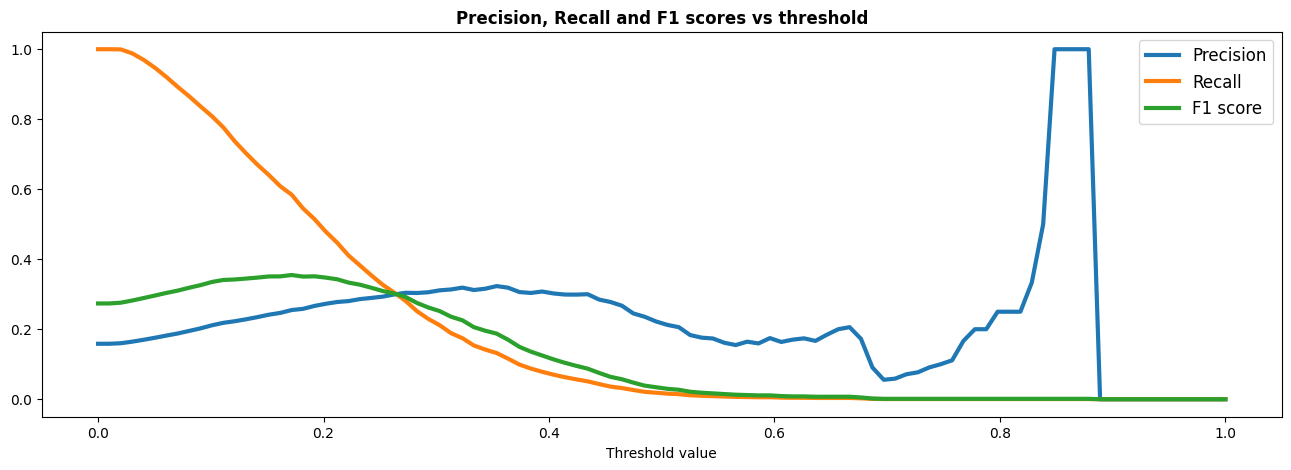

In [57]:
fig = plt.figure(figsize=(16, 5))

plt.plot(tr, p, linewidth=3)
plt.plot(tr, r, linewidth=3)
plt.plot(tr, f, linewidth=3)

plt.title("Precision, Recall and F1 scores vs threshold", weight="bold")

plt.xlabel("Threshold value")

plt.legend(['Precision', 'Recall', 'F1 score'], fontsize=12)

plt.show()

**From the graph we can see that it is fairly reasinble to leave the threshhold at the level Target_mean level of 0.1595906423188216**

In [62]:
# By default threshhold is 0.5 BUT to increase the RECALL in OUR CREDIT SCORING we've chosen it to be rqual to Target mean level.
# Get probability predictions for the positive class
y_pred_proba = best_lgbm_model.predict_proba(X_test_scaled)[:, 1]

# Define your custom threshold
custom_threshold = 0.1595906423188216

# Apply the custom threshold to determine class labels
y_pred_custom = np.where(y_pred_proba >= custom_threshold, 1, 0)

y_pred_custom



array([0, 0, 0, ..., 0, 0, 1])

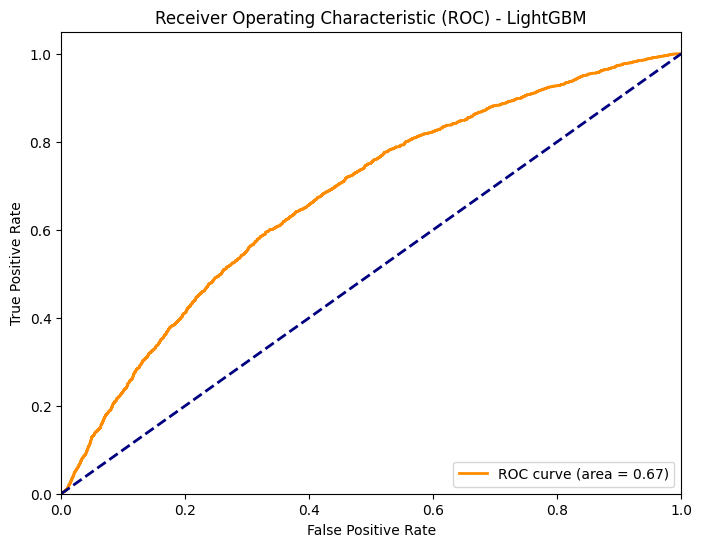

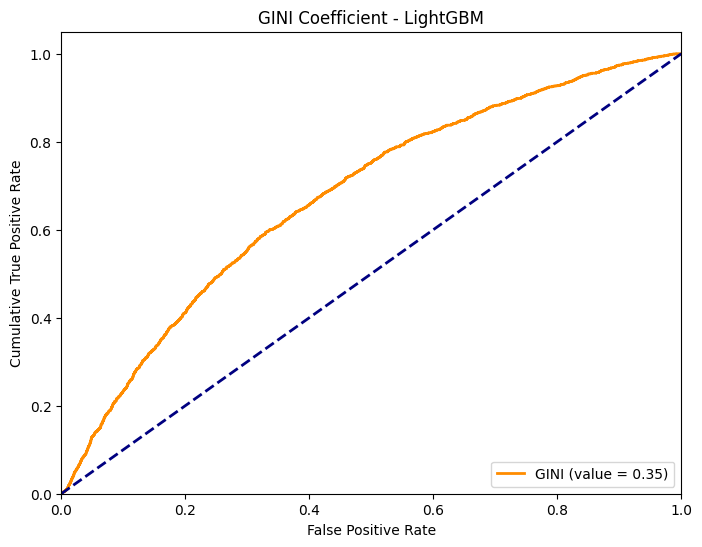

In [50]:
# Obtain probability scores using the best estimator
y_scores = RS_lgbm.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Calculating True Positive Rate and False Positive Rate for ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - LightGBM')
plt.legend(loc="lower right")
plt.show()

# GINI calculation
gini = 2 * roc_auc - 1

# Plotting the GINI curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='GINI (value = %0.2f)' % gini)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Cumulative True Positive Rate')
plt.title('GINI Coefficient - LightGBM')
plt.legend(loc="lower right")
plt.show()


LightGBM's results on the test set are not so great. BUt that's the best you've achieved so far given time constraints. So, let's use it as it is.

## Step 3: Risk-Based Pricing and Decision-Making Strategy

In [63]:
# Using new clients data
nc = pd.read_csv('/content/drive/MyDrive/RISK MANAGEMENT/new_clients_for_scoring.csv')
print(nc.shape)
nc.head()

(60333, 22)


,client_id,issue_d,purpose,addr_state,sub_grade,home_ownership,emp_title,dti,funded_amnt,annual_inc,...,inq_last_6mths,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt
0,0,6/1/2014,credit_card,AR,A5,RENT,Property Manager,26.72,15000,45000.0,...,0,9.0,0,0,0,0,4,7245,56948,0
1,1,6/1/2014,credit_card,VA,C4,MORTGAGE,VP Sales,12.62,31500,200000.0,...,2,0.0,1,0,0,0,4,54598,641658,0
2,2,6/1/2014,credit_card,TX,A4,RENT,Engineer in Training,27.72,6400,46500.0,...,0,7.0,0,0,0,0,3,8376,120218,0
3,3,6/1/2014,debt_consolidation,TX,D3,MORTGAGE,Manager,25.68,15000,68700.0,...,0,18.0,2,0,2,1,3,5028,70899,0
4,4,6/1/2014,other,VA,C2,MORTGAGE,Sr. Acct. Mgr.,6.80,3000,114435.0,...,0,8.0,0,0,0,0,2,28455,281150,0


In [74]:
income_brackets = [-1, 50000, 100000, 150000, float('inf')]
income_labels = ['Low', 'Medium', 'High', 'Very High']
nc['income_category'] = pd.cut(nc['annual_inc'], bins=income_brackets, labels=income_labels)
nc['income_category'].value_counts()

Medium       29633
Low          19805
High          7848
Very High     3047
Name: income_category, dtype: int64

In [75]:
emp_length_brackets = [-1, 1, 3, 5, 10, float('inf')]
emp_length_labels = ['<1yr', '1-3yrs', '3-5yrs', '5-10yrs', '>10yrs']
nc['emp_length_category'] = pd.cut(nc['emp_length'], bins=emp_length_brackets, labels=emp_length_labels)
nc['emp_length_category'].value_counts()

5-10yrs    31529
1-3yrs     10190
<1yr        8683
3-5yrs      6796
>10yrs         0
Name: emp_length_category, dtype: int64

In [81]:
#categorical_cols = nc.select_dtypes(include=['object', 'category']).columns.tolist()

# # Add 'Missing' as a category for each categorical column
# for col in categorical_cols:
#     if nc[col].dtype.name == 'category':
#         nc[col] = nc[col].cat.add_categories('Missing')
#     nc[col] = nc[col].fillna('Missing')

# # Recalculate the number of null values
# null_val_sums_2 = nc.isnull().sum()

# # Creating DataFrame to display the information
# pd.DataFrame({"Column": null_val_sums_2.index,
#               "Number of Null Values": null_val_sums_2.values,
#               "Proportion": null_val_sums_2.values / len(nc)})

In [86]:
nc_2 = nc.drop(['client_id'], axis=1)
nc_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60333 entries, 0 to 60332
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   issue_d                   60333 non-null  object  
 1   purpose                   60333 non-null  object  
 2   addr_state                60333 non-null  object  
 3   sub_grade                 60333 non-null  object  
 4   home_ownership            60333 non-null  object  
 5   emp_title                 60333 non-null  object  
 6   dti                       60333 non-null  float64 
 7   funded_amnt               60333 non-null  int64   
 8   annual_inc                60333 non-null  float64 
 9   emp_length                57198 non-null  float64 
 10  term                      60333 non-null  int64   
 11  inq_last_6mths            60333 non-null  int64   
 12  mths_since_recent_inq     54344 non-null  float64 
 13  delinq_2yrs               60333 non-null  int6

In [84]:
categorical_cols = nc_2.select_dtypes(include=['object', 'category']).columns.tolist()

In [92]:

# Define categorical and numerical columns based on your training dataset
numerical_cols = nc_2.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocess the new client data
new_clients_transformed = pipeline.transform(nc_2)

# Convert the transformed data back into a DataFrame
# The column names will be the same as in X_train_scaled
new_clients_scaled = pd.DataFrame(new_clients_transformed, columns=nc_2.columns)

# Predict PD for new clients
nc_2['PD'] = RS_lgbm.best_estimator_.predict_proba(new_clients_transformed)[:, 1]


In [93]:
nc_2.head()

,issue_d,purpose,addr_state,sub_grade,home_ownership,emp_title,dti,funded_amnt,annual_inc,emp_length,...,chargeoff_within_12_mths,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt,income_category,emp_length_category,PD
0,6/1/2014,credit_card,AR,A5,RENT,Property Manager,26.72,15000,45000.0,7.0,...,0,0,0,4,7245,56948,0,Low,5-10yrs,0.175818
1,6/1/2014,credit_card,VA,C4,MORTGAGE,VP Sales,12.62,31500,200000.0,10.0,...,0,0,0,4,54598,641658,0,Very High,5-10yrs,0.223877
2,6/1/2014,credit_card,TX,A4,RENT,Engineer in Training,27.72,6400,46500.0,1.0,...,0,0,0,3,8376,120218,0,Low,<1yr,0.063100
3,6/1/2014,debt_consolidation,TX,D3,MORTGAGE,Manager,25.68,15000,68700.0,7.0,...,0,2,1,3,5028,70899,0,Medium,5-10yrs,0.138454
4,6/1/2014,other,VA,C2,MORTGAGE,Sr. Acct. Mgr.,6.80,3000,114435.0,10.0,...,0,0,0,2,28455,281150,0,High,5-10yrs,0.067899


In [94]:
Team4_answer = pd.DataFrame({
    'client_id': nc['client_id'],
    'PD': nc_2['PD']
})


In [95]:
Team4_answer.head()

,client_id,PD
0,0,0.175818
1,1,0.223877
2,2,0.063100
3,3,0.138454
4,4,0.067899


### Optimal Rate Calculation

In [99]:
nc_2['term'].value_counts()

36    40718
60    19615
Name: term, dtype: int64

In [101]:
from scipy.optimize import minimize_scalar

# Define constants
r0 = f = 0.08  # 8% annual risk-free and borrowing interest rate

# Function to calculate r_n
def calculate_r_n(r):
    return (1 + r) ** (1/12) - 1

def calculate_e_pnl(r, pd, s, term):
    r_n = calculate_r_n(r)
    r0_n = calculate_r_n(r0)
    f_n = calculate_r_n(f)

    term1 = (1 - 0.6 * pd) * r_n * (1 + r_n)**term / ((1 + r_n)**term - 1) * s
    term2 = ((1 + r0_n)**term - 1) / r0_n
    term3 = (1 + f_n)**term * s

    return term1 * term2 - term3

# Optimization function for a single client with term length
def optimize_rate_for_client(pd, s, term):
    obj_func = lambda r: -calculate_e_pnl(r, pd, s, term)
    bounds = (0.05, 0.30)  # Bounds for the interest rate
    result = minimize_scalar(obj_func, bounds=bounds, method='bounded')
    optimal_rate = result.x if calculate_e_pnl(result.x, pd, s, term) > 0 else 0
    return optimal_rate

# Apply the optimization for each client
nc_2['optimal_rate'] = nc_2.apply(lambda x: optimize_rate_for_client(x['PD'], x['funded_amnt'], x['term']), axis=1)



In [104]:
nc_2.head()

,issue_d,purpose,addr_state,sub_grade,home_ownership,emp_title,dti,funded_amnt,annual_inc,emp_length,...,num_accts_ever_120_pd,num_tl_90g_dpd_24m,acc_open_past_24mths,avg_cur_bal,tot_hi_cred_lim,delinq_amnt,income_category,emp_length_category,PD,optimal_rate
0,6/1/2014,credit_card,AR,A5,RENT,Property Manager,26.72,15000,45000.0,7.0,...,0,0,4,7245,56948,0,Low,5-10yrs,0.175818,0.299994
1,6/1/2014,credit_card,VA,C4,MORTGAGE,VP Sales,12.62,31500,200000.0,10.0,...,0,0,4,54598,641658,0,Very High,5-10yrs,0.223877,0.299994
2,6/1/2014,credit_card,TX,A4,RENT,Engineer in Training,27.72,6400,46500.0,1.0,...,0,0,3,8376,120218,0,Low,<1yr,0.063100,0.299994
3,6/1/2014,debt_consolidation,TX,D3,MORTGAGE,Manager,25.68,15000,68700.0,7.0,...,2,1,3,5028,70899,0,Medium,5-10yrs,0.138454,0.299994
4,6/1/2014,other,VA,C2,MORTGAGE,Sr. Acct. Mgr.,6.80,3000,114435.0,10.0,...,0,0,2,28455,281150,0,High,5-10yrs,0.067899,0.299994


In [106]:
nc_2['optimal_rate'].value_counts()

0.299994    58915
0.000000     1418
Name: optimal_rate, dtype: int64

**We see that an additional constraint should be included to account for PD.**

we take minimal rate as 9% to be higher that risk free and to cover costs of the bank at least to some extent.

In [150]:
import numpy as np
from scipy.optimize import minimize_scalar

# Constants
r0 = f = 0.08  # Annual risk-free and borrowing interest rate
min_rate = 0.09  # Minimum rate
max_rate = 0.30  # Maximum rate

# Monthly rate from annual rate
def calculate_r_n(r):
    return (1 + r) ** (1/12) - 1

# E(PNL) with term length as a parameter, incorporating non-linearity
def calculate_e_pnl(r, pd, s, term):
    r_n = calculate_r_n(r)
    r0_n = calculate_r_n(r0)
    f_n = calculate_r_n(f)

    if (1 + r_n)**term - 1 == 0:
        return -np.inf

    # Non-linear risk term that penalizes high PD with higher rates
    risk_term = pd * r ** 2

    term1 = (1 - risk_term) * r_n * (1 + r_n)**term / ((1 + r_n)**term - 1) * s
    term2 = ((1 + r0_n)**term - 1) / r0_n
    term3 = (1 + f_n)**term * s

    return term1 * term2 - term3

# Rate based on PD, increasing with PD
def rate_based_on_pd(pd):
    # Linear increase from min_rate at PD = 0 to max_rate at PD = 1
    rate_increase = max_rate - min_rate
    return min_rate + pd * rate_increase

# Optimization function for a single client
def optimize_rate_for_client(pd, s, term):
    obj_func = lambda r: -calculate_e_pnl(r, pd, s, term)
    bounds = (min_rate, rate_based_on_pd(pd))
    result = minimize_scalar(obj_func, bounds=bounds, method='bounded')
    return result.x if result.fun < 0 else np.nan  # fun is the minimized value of E(PNL)

# Assuming nc_2 is your DataFrame with new client data

# Apply the optimization to find the optimal rate for each client
nc_2['optimal_rate'] = nc_2.apply(
    lambda x: optimize_rate_for_client(x['PD'], x['funded_amnt'], x['term']), axis=1
)



In [151]:
nc_2['optimal_rate'].value_counts()

0.092591    2
0.126915    1
0.098843    1
0.102288    1
0.171305    1
           ..
0.149082    1
0.122446    1
0.101697    1
0.107842    1
0.100275    1
Name: optimal_rate, Length: 60332, dtype: int64

In [152]:
num_zero_rates = (nc_2['optimal_rate'] == 0.0).sum()
num_zero_rates

0

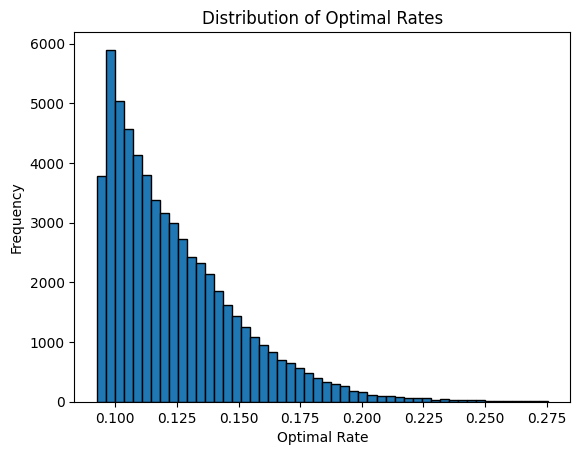

In [156]:
# Drop NA values in case there are any, and plot the histogram
plt.hist(nc_2['optimal_rate'].dropna(), bins=50, edgecolor='black')

# Set the title and labels
plt.title('Distribution of Optimal Rates')
plt.xlabel('Optimal Rate')
plt.ylabel('Frequency')

# Show the plot
plt.show()


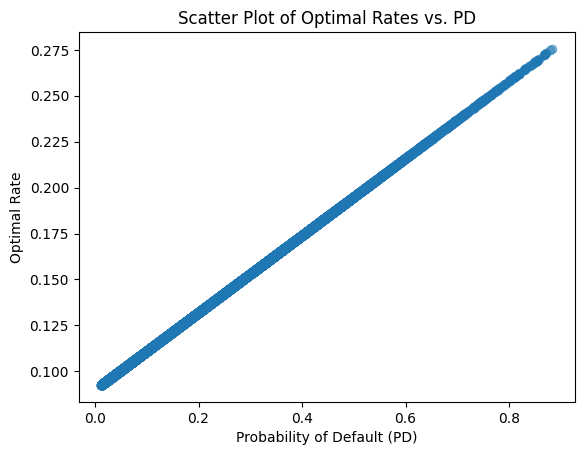

In [157]:
# Create a scatter plot of PD vs. optimal rates
plt.scatter(nc_2['PD'], nc_2['optimal_rate'], alpha=0.5)

# Set the title and labels
plt.title('Scatter Plot of Optimal Rates vs. PD')
plt.xlabel('Probability of Default (PD)')
plt.ylabel('Optimal Rate')

# Show the plot
plt.show()


In [153]:
Team4_answer = pd.DataFrame({
    'client_id': nc['client_id'],
    'PD': nc_2['PD'],
    'rate_offered' : nc_2['optimal_rate']
})

In [154]:
Team4_answer

,client_id,PD,rate_offered
0,0,0.175818,0.126915
1,1,0.223877,0.137009
2,2,0.063100,0.103245
3,3,0.138454,0.119071
4,4,0.067899,0.104252
...,...,...,...
60328,60328,0.193275,0.130584
60329,60329,0.247910,0.142055
60330,60330,0.159613,0.123513
60331,60331,0.123956,0.116027


In [155]:

Team4_answer.to_csv('/content/drive/My Drive/RISK MANAGEMENT/Team4_answer.csv', index=False, sep=',')
